In [5]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "./")

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ERROR: Error in library(tidyverse): there is no package called 'tidyverse'


In [3]:
data <- read.csv("Earthquate_Damage.csv")
perf_eval_multi <- function(cm){
  
  # Simple Accuracy
  ACC = sum(diag(cm))/sum(cm)
  
  # Balanced Correction Rate
  BCR = 1
  for (i in 1:dim(cm)[1]){
    BCR = BCR*(cm[i,i]/sum(cm[i,])) 
  }
  
  BCR = BCR^(1/dim(cm)[1])
  
  return(c(ACC, BCR))
}
set.seed(42)
trn_idx <- sample(1:nrow(data), 150000)
train <- data[trn_idx,]
tmp <- data[-trn_idx,]
val_idx <- sample(1:nrow(tmp),50000)
val <- tmp[val_idx,]
test <- tmp[-val_idx,]
all_train <- rbind(train,val)
val$damage_grade <- as.factor(val$damage_grade)
train$damage_grade <- as.factor(train$damage_grade)
all_train$damage_grade <- as.factor(all_train$damage_grade)
test$damage_grade <- as.factor(test$damage_grade)
x_train <- train[,!(names(train)%in%"damage_grade")]
y_train <- train[,(names(train)%in%"damage_grade")]
x_val <- val[,!(names(val)%in%"damage_grade")]
y_val <- val[,(names(val)%in%"damage_grade")]
x_test <- test[,!(names(test)%in%"damage_grade")]
y_test <- test[,(names(test)%in%"damage_grade")]
x_all_train <- all_train[,!(names(all_train)%in%"damage_grade")]
y_all_train <- all_train[,(names(all_train)%in%"damage_grade")]

In [4]:
install.packages("gbm")
library(gbm)

also installing the dependency 'gridExtra'




package 'gridExtra' successfully unpacked and MD5 sums checked
package 'gbm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\lmwlm\AppData\Local\Temp\RtmpM3KVI9\downloaded_packages


Loaded gbm 2.1.5



In [4]:
n_trees <- c(50,100,150)
shrinkage <- c(0.1,0.01,0.001)
interaction_depth <- c(2,3,4)
# depth 3,5,7 n.trees 100 500 1000일때 램이 터졌음
# depth 100,200,300 , 2,3,4일때 또 터짐

In [7]:
gbm_pre_result = matrix(0,27,5)
colnames(gbm_pre_result) <- c("n.trees","shrinkage","interaction.depth","ACC", "BCR")

In [8]:
iters_cnt <- 1
for(i in 1:3){
    for(j in 1:3){
        for(k in 1:3){
            tmp_model <- gbm.fit(x_train, y_train, verbose=0,
                 n.trees = n_trees[i], shrinkage = shrinkage[j],distribution="multinomial",interaction.depth = interaction_depth[k])
            tmp_prey <- predict(tmp_model,newdata=x_val,n.trees=n_trees[i], type = "response")
            dim(tmp_prey)<-c(50000,3)
            tmp_prey <- apply(tmp_prey, 1, which.max)
            tmp_cm <- table(tmp_prey,y_val)
            gbm_pre_result[iters_cnt,1] <- n_trees[i]
            gbm_pre_result[iters_cnt,2] <- shrinkage[j]
            gbm_pre_result[iters_cnt,3] <- interaction_depth[k]
            gbm_pre_result[iters_cnt,4:5] <- perf_eval_multi(tmp_cm)
            iters_cnt <- iters_cnt+1
            gc()
        }
    }
}

In [9]:
gbm_pre_result

n.trees,shrinkage,interaction.depth,ACC,BCR
50,0.100,2,0.65162,0.6687165
50,0.100,3,0.66624,0.6640815
50,0.100,4,0.67452,0.6670167
50,0.010,2,0.62734,0.4949843
50,0.010,3,0.63470,0.6796874
50,0.010,4,0.64462,0.6530733
50,0.001,2,0.09572,0.0957200
50,0.001,3,0.63110,0.6513730
50,0.001,4,0.62542,0.5966587
100,0.100,2,0.66932,0.6631516


In [10]:
# 150 0.1, 4

In [6]:
gbm_model <- gbm.fit(x_all_train, y_all_train, verbose=0,
                 n.trees = 150, shrinkage = 0.1,distribution="multinomial",interaction.depth = 4)

In [10]:
pred <- predict(gbm_model,newdata=x_test,n.trees=150, type = "response")
dim(pred)<-c(60601,3)
pred <- apply(pred, 1, which.max)
cm <- table(pred,y_test)
perf_eval_multi(cm)

[1] 0.6933054 0.6862727

,var,rel.inf
,<fct>,<dbl>
geo_level_1_id,geo_level_1_id,50.4463455
foundation_type,foundation_type,16.5055923
geo_level_2_id,geo_level_2_id,6.9029915
ground_floor_type,ground_floor_type,6.4646776
other_floor_type,other_floor_type,3.6473149
has_superstructure_mud_mortar_stone,has_superstructure_mud_mortar_stone,2.9560760
age,age,2.9318106
has_superstructure_cement_mortar_brick,has_superstructure_cement_mortar_brick,2.1227524
geo_level_3_id,geo_level_3_id,1.4156718


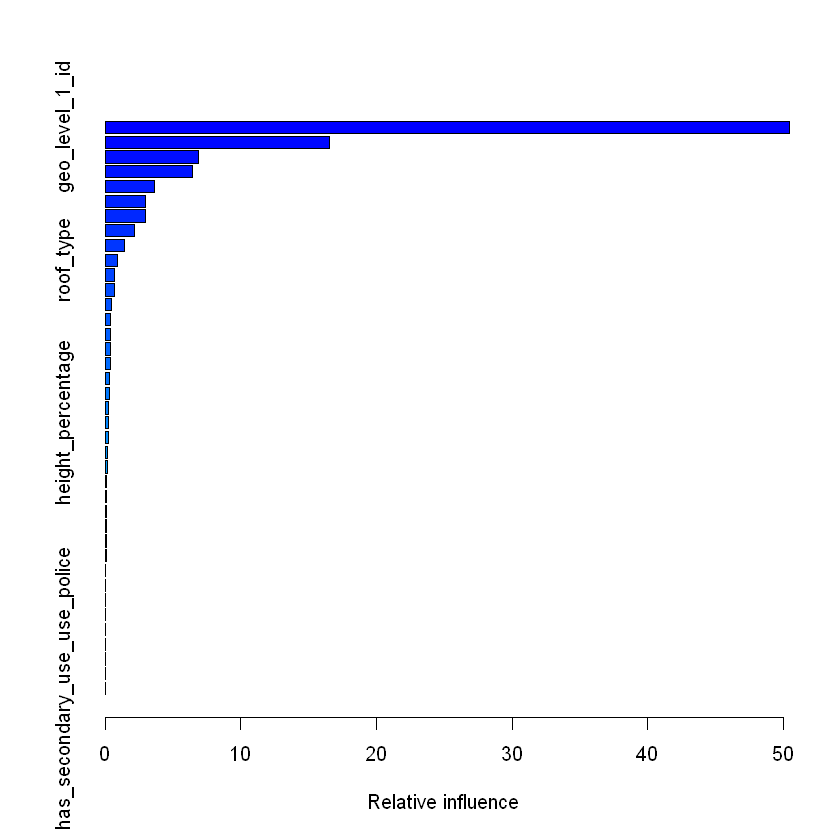

In [11]:
summary(gbm_model)[1:10,]

In [ ]:
summary(gbm_model)[1:10,]